# Train Model with CPU

In [2]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

## Reset TensorFlow Graph
Useful in Jupyter Notebooks

In [3]:
tf.reset_default_graph()

## Create TensorFlow Session

In [4]:
sess = tf.Session()
print(sess)

In [5]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

### Load Model Training and Test/Validation Data 


In [6]:
num_samples = 100000

[ 0.65496665  0.86783111  0.50193542 ...,  0.91025114  0.86611038  0.310561  ]
[ 0.36915103  0.3899642   0.3623527  ...,  0.38802906  0.39148579
  0.33731012]


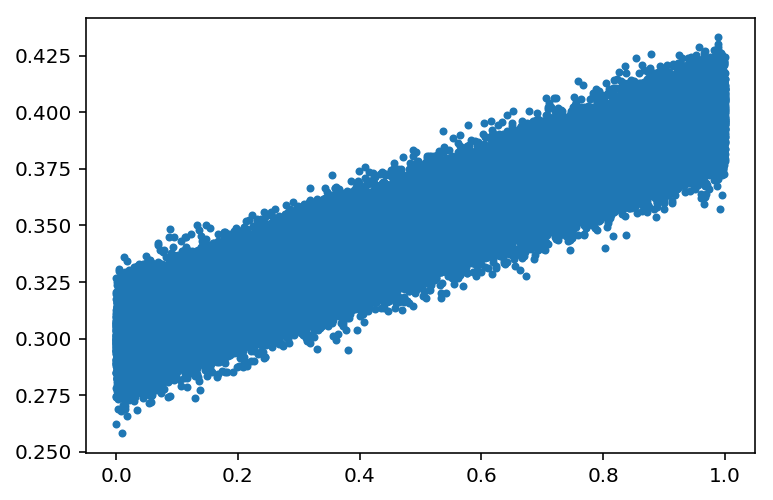

In [7]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[ 0.16483045  0.04662701  0.95630658 ...,  0.22195032  0.57822067
  0.41864085]
[ 0.31898594  0.30943618  0.40663332 ...,  0.31662388  0.34974381
  0.3358874 ]


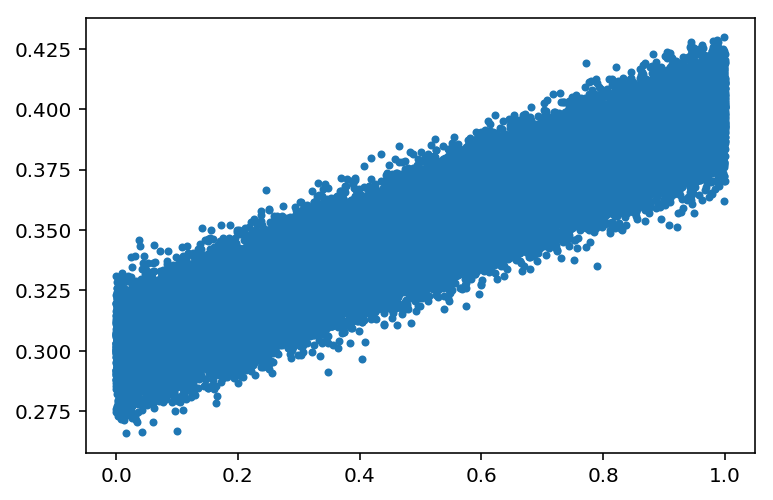

In [8]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [9]:
with tf.device("/cpu:0"):
    W = tf.get_variable(shape=[], name='weights')
    print(W)

    b = tf.get_variable(shape=[], name='bias')
    print(b)

    x_observed = tf.placeholder(shape=[None], 
                                dtype=tf.float32, 
                                name='x_observed')
    print(x_observed)

    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:CPU:0)


In [10]:
learning_rate = 0.025

with tf.device("/cpu:0"):
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
    optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    
    train_op = optimizer_op.minimize(loss_op)  

    print("Loss Scalar: ", loss_op)
    print("Optimizer Op: ", optimizer_op)
    print("Train Op: ", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Loss Scalar:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
Optimizer Op:  <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7fe4b01d8358>
Train Op:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [11]:
with tf.device("/cpu:0"):
    init_op = tf.global_variables_initializer()
    print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [12]:
sess.run(init_op)
print("Initial random W: %f" % sess.run(W))
print("Initial random b: %f" % sess.run(b))

Initial random W: 0.984795
Initial random b: -1.718099


## View Model Graph in Tensorboard

http://[ip-address]:6006

## View Accuracy of Pre-Training, Initial Random Variables
This should be relatively low.

In [13]:
def test(x, y):
    return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [14]:
test(x_train, y_train)

2.5466652

## Setup Loss Summary Operations for Tensorboard

In [15]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

In [16]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/train' % version, 
                                            graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/test' % version,
                                            graph=tf.get_default_graph())

## Train Model

In [17]:
%%time

with tf.device("/cpu:0"):
    run_metadata = tf.RunMetadata()
    max_steps = 401
    for step in range(max_steps):
        if (step < max_steps - 1):
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
        else:  
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                            options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), 
                                            run_metadata=run_metadata)

            trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
            with open('cpu-timeline.json', 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

        if step % 10 == 0:
            print(step, sess.run([W, b]))
            train_summary_writer.add_summary(train_summary_log, step)
            train_summary_writer.flush()
            test_summary_writer.add_summary(test_summary_log, step)
            test_summary_writer.flush()

0 [1.0205239, -1.6393396]
10 [1.2604798, -1.07291]
20 [1.3629935, -0.7668547]
30 [1.3948365, -0.5964222]
40 [1.3906666, -0.49680409]
50 [1.368463, -0.43432659]
60 [1.3375421, -0.39148799]
70 [1.3027219, -0.35918656]
80 [1.2664845, -0.33268392]
90 [1.2300996, -0.30950847]
100 [1.1942068, -0.28836614]
110 [1.1591208, -0.26857492]
120 [1.1249869, -0.249771]
130 [1.0918629, -0.23175623]
140 [1.0597627, -0.21441865]
150 [1.0286772, -0.19769154]
160 [0.99858594, -0.18153185]
170 [0.96946281, -0.16590899]
180 [0.94128007, -0.15079932]
190 [0.91400892, -0.13618293]
200 [0.88762075, -0.12204213]
210 [0.86208743, -0.10836066]
220 [0.83738136, -0.095123127]
230 [0.81347603, -0.082314923]
240 [0.79034555, -0.069922]
250 [0.76796478, -0.057930876]
260 [0.74630946, -0.046328474]
270 [0.72535604, -0.03510217]
280 [0.70508182, -0.024239765]
290 [0.68546474, -0.013729458]
300 [0.66648346, -0.0035598308]
310 [0.64811754, 0.006280161]
320 [0.63034683, 0.015801203]
330 [0.61315215, 0.025013637]
340 [0.596

(0, 1.0)

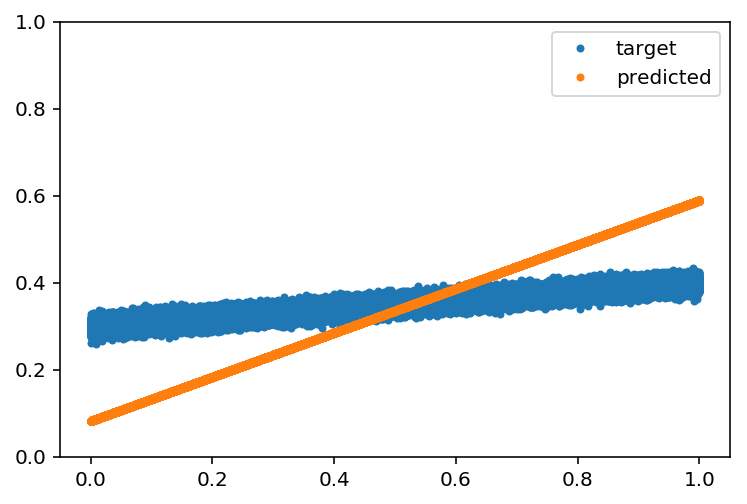

In [18]:
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, 
                             feed_dict={x_observed: x_train, 
                                        y_observed: y_train}), 
           ".", 
           label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

## View Loss Summaries in Tensorboard

Navigate to the Scalars tab at this URL:

http://[ip-address]:6006

## Save Model for Deployment and Inference

In [19]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

name: "x_observed:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "add:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}



In [20]:
export_path = "/root/models/linear/cpu/%s" % version
print(export_path)

/root/models/linear/cpu/1494514140


In [21]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

builder = saved_model_builder.SavedModelBuilder(export_path)

prediction_signature =  signature_def_utils.build_signature_def(inputs = 
                        {'x_observed': tensor_info_x_observed}, 
                        outputs = {'y_pred': tensor_info_y_pred}, 
                        method_name = signature_constants.PREDICT_METHOD_NAME)

legacy_init_op = tf.group(tf.initialize_all_tables(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
                                     signature_def_map={'predict':prediction_signature, signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
                                     legacy_init_op=legacy_init_op)

builder.save()

Instructions for updating:
Use `tf.tables_initializer` instead.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/root/models/linear/cpu/1494514140/saved_model.pb'


b'/root/models/linear/cpu/1494514140/saved_model.pb'

### View Saved Model on Disk

You must replace `[version]` with the version number from above ^^

In [22]:
%%bash

# You must replace `[version]` with the version number from above ^^
ls -l /root/models/linear/cpu/[version]

ls: cannot access '/root/models/linear/cpu/[version]': No such file or directory


## Save Graph For Optimization
We will use this later.

In [23]:
from tensorflow.python.framework import graph_io

graph_io.write_graph(sess.graph, 
                     "/root/models/optimize_me/", 
                     "unoptimized_cpu.pb",
                     as_text=False)

'/root/models/optimize_me/unoptimized_cpu.pb'

In [24]:
sess.close()